In [1]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage
import copy

np.random.seed(2020)


In [2]:
# Read in Data
with open('data/sem_items_new.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_relations_new.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_attributes_new.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])

In [3]:
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(*names_items,sep=',')
print("\nList of relations:")
print(*names_relations,sep=',')
print("\nList of attributes:")
print(*names_attributes,sep=',')

List of items:
Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile

List of relations:
ISA,Is,Can,Has

List of attributes:
Living thing,Plant,Animal,Tree,Flower,Bird,Fish,Reptile,Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile,Pretty,Big,Living,Green,Red,Yellow,Slow,Grow,Move,Swim,Fly,Sing,Skin,Roots,Leaves,Bark,Branch,Petals,Wings,Feathers,Gills,Scales,Backbone,Produce Eggs,Shell


In [4]:
item_display_ind = 35 # can change, just represents index of input data to show as example.

D = np.loadtxt('data/sem_data_new.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns



input_v = input_pats[item_display_ind,:].numpy().astype('bool')
output_v = output_pats[item_display_ind,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:nobj]])
print('Relation ',end='')
print(names_relations[input_v[nobj:]])
print('Attributes ',end='')
print(names_attributes[output_v])

Example input pattern:
[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 1]

Which encodes...
Item ['Turtle']
Relation ['Has']
Attributes ['Skin' 'Backbone' 'Shell']


In [5]:
class Net(nn.Module):
    def __init__(self, n_items, n_relations, n_attributes, rep_layer_size, hidden_layer_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        self.n_items = n_items # input to rep
        self.n_relations = n_relations # input to hidden
        self.n_attributes = n_attributes # output        
        
        self.i2rep = nn.Linear(self.n_items, rep_layer_size,bias=False)
        self.all2h = nn.Linear(rep_layer_size+self.n_relations, hidden_layer_size,bias=False)
        self.h2o   = nn.Linear(hidden_layer_size, self.n_attributes,bias=False)
        
        # initialize untrainable bias.
        #self.i2rep.bias = nn.Parameter(torch.ones(1,self.n_items),requires_grad=False)
        #self.all2h.bias = nn.Parameter(torch.ones(1,hidden_layer_size),requires_grad=False)
        #self.h2o.bias = nn.Parameter(torch.ones(1,self.n_attributes),requires_grad=False)
        
        # initialize weights.
        nn.init.uniform_(self.i2rep.weight,-1.643,1.643)
        nn.init.uniform_(self.all2h.weight,-1.643,1.643)
        nn.init.uniform_(self.h2o.weight,-1.643,1.643)
                
    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x      = x.view(-1, self.n_items+self.n_relations) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:self.n_items] # input to Item Layer [B x nobj Tensor]
        x_rel  = x[:,self.n_items:] # input to Relation Layer [B x nrel Tensor]

        rep             = relu(self.i2rep(x_item))
        input_to_hidden = torch.cat((rep,x_rel), dim=1)
        hidden          = relu(self.all2h(input_to_hidden))
        output          = torch.sigmoid(self.h2o(hidden))
                
        return output, hidden, rep
    

In [281]:
loaded_model = torch.load('trained_model.pt')

mynet = Net(nobj,nrel, nattributes,rep_layer_size=loaded_model['model_state_dict']['i2rep.weight'].size()[0],
            hidden_layer_size=loaded_model['model_state_dict']['all2h.weight'].size()[0])

mynet.load_state_dict(loaded_model['model_state_dict'])
mynet.eval()

Net(
  (i2rep): Linear(in_features=10, out_features=12, bias=False)
  (all2h): Linear(in_features=16, out_features=16, bias=False)
  (h2o): Linear(in_features=16, out_features=43, bias=False)
)

## Model Has been Loaded successfully, now evaluate model

In [18]:
# This will iterate through each possible input pattern, predict outputs, and determine
# if the output matches the expected output. If not, it prints the input pattern index

# ***Should return nothing when ran, unless using MSELoss (which it is)

for i in range(input_pats.shape[0]) :
    output = mynet(input_pats[i])[0][0].detach().numpy()
    if np.dot(output_pats[i].numpy(),np.where(output>=.5,1,0)) != np.sum(output_pats[i].numpy()) :
        print(i,' BAD')
    else :
        if np.sum(np.where(output>=.5,1,0)) != np.sum(output_pats[i].numpy()) :
            print(i,' BAD (extra attributes predicted)')
        
# Uses the fact that the sigmoid for multiclass will have to be >= .5 to be considered a positive result.
# Measures the overlap between input and output, but also measures if there are extra labels considered positive.

0  BAD
1  BAD


### Need to bucket attributes into "general" , "intermediate", and "specific"

In [7]:
general = names_attributes[1:3]
intermediate = names_attributes[3:8]
specific = names_attributes[8:]

In [11]:
relation_eval = 'ISA'
ind_relation = np.where(names_relations == relation_eval)[0][0]

patterns_eval = input_pats[ind_relation::len(names_relations)]
patterns_truth = output_pats[ind_relation::len(names_relations)]

## Noise introduction (gaussian sampling)

In [212]:
def apply_gaussian_noise(net,scale) :
    
    model = copy.deepcopy(net) #otherwise actual model might change in place.
    model.eval()
    new_weights = model.state_dict()

    
    # add mutlivariate random matrix element-wise to weights.
    noisy_add = np.random.normal(loc=0,scale=scale,
                                 size=new_weights['i2rep.weight'].size())
    
    new_weights['i2rep.weight'] += noisy_add
    model.load_state_dict(new_weights)
    
    return model

In [228]:
def apply_dropout_noise(net,probability) :
    
    model = copy.deepcopy(net) #otherwise actual model might change in place.
    model.eval()
    new_weights = model.state_dict()

    dim1,dim2 = new_weights['i2rep.weight'].size()
    
    rand_use = np.random.random(size=dim1) > probability
    weights_new = (rand_use.astype(int)).reshape(dim1,1) * new_weights['i2rep.weight'].detach().numpy()
    
    new_weights['i2rep.weight'] = torch.tensor(weights_new)
    model.load_state_dict(new_weights)
    
    return model

In [213]:
def Categorize_Outputs(net,general_names,intermediate_names,specific_names,relation_eval='ISA') :
    
    ind_relation = np.where(names_relations == relation_eval)[0][0]

    patterns_eval = input_pats[ind_relation::len(names_relations)]
    patterns_truth = output_pats[ind_relation::len(names_relations)]
    general_out = []
    intermediate_out = []
    specific_out = []
    negative_out = []

    for i,pattern in enumerate(patterns_eval) :
        true_output_bool = patterns_truth[i].detach().numpy().astype('bool')
        names_eval = names_attributes[true_output_bool]
        mod_output = net(pattern)[0].detach().numpy()[0][true_output_bool]  
        for j,name in enumerate(names_eval) :
            if name in general_names :
                general_out.append(mod_output[j])
            if name in intermediate_names :
                intermediate_out.append(mod_output[j])
            if name in specific_names :
                specific_out.append(mod_output[j])
                
    inds_truth = np.argwhere(patterns_truth.detach().numpy())
    inds_false = np.argwhere(patterns_truth.detach().numpy() == 0)

    inds_false = inds_false[np.isin(inds_false[:,1],list(set(inds_truth[:,1])))]
    negative_outputs = net(patterns_eval)[0].detach().numpy()[inds_false[:,0],inds_false[:,1]]
                
    return np.mean(general_out),np.mean(intermediate_out),np.mean(specific_out),np.mean(negative_outputs)

In [214]:
def Noise_Degredation(net,scales,num_run,fnc_noise,fnc_categorize,general_names,
                      intermediate_names,specific_names,relation_eval='ISA') :
    
    noise_stats = {item:{scale:[] for scale in scales} for 
                   item in ['general','intermediate','specific','negative']}

    for scale in scales :
        for _ in range(num_run) :
            model = fnc_noise(net,scale)
            g_out,int_out,s_out,neg_out = fnc_categorize(model,general_names,intermediate_names,
                                                 specific_names,relation_eval)
            
            noise_stats['general'][scale].append(g_out)
            noise_stats['intermediate'][scale].append(int_out)
            noise_stats['specific'][scale].append(s_out)
            noise_stats['negative'][scale].append(neg_out)
            
    return noise_stats

In [237]:
scales_use = np.linspace(0,2,10)
relation_use = 'ISA'
test = Noise_Degredation(mynet,scales_use,50,apply_gaussian_noise,Categorize_Outputs,
                         general,intermediate,specific,relation_use)

In [238]:
test_formatted = {} 
for k,v in test.items() :
    test_formatted[k] = {}
    for scale,vals in v.items() :
        test_formatted[k][scale] = {}
        test_formatted[k][scale]['mean'] = np.mean(vals,axis=0)
        test_formatted[k][scale]['std'] = np.std(vals,axis=0)


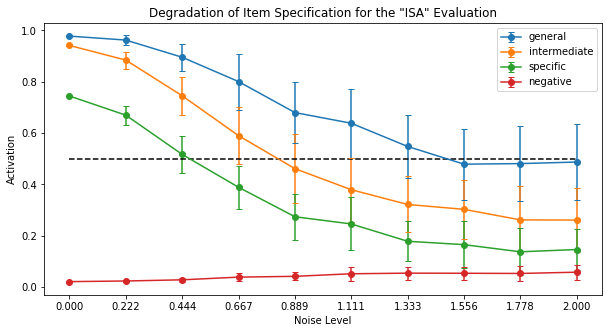

In [239]:
plt.figure(figsize=(10,5))
for k,v in test_formatted.items() :
    #if k == 'negative' :
    #    continue
    to_plot = [v[scale]['mean'] for scale in v.keys()]
    to_plot_error = [v[scale]['std'] for scale in v.keys()]
    plt.errorbar(scales_use,to_plot,yerr=to_plot_error,label=k,linestye=None,marker='o',capsize=3)
    
plt.hlines(y=.5,xmin=0,xmax=max(scales_use),linestyle='--')
plt.legend()
plt.xticks(scales_use)
plt.title('Degradation of Item Specification for the "{}" Evaluation'.format(relation_use))
plt.xlabel('Noise Level')
plt.ylabel('Activation')
plt.show()

## Noise introduction (Node Dropout)

In [240]:
probabilities_use = np.linspace(0,1,10)
relation_use= 'ISA'
test = Noise_Degredation(mynet,probabilities_use,50,apply_dropout_noise,Categorize_Outputs,
                         general,intermediate,specific,relation_use)

In [241]:
test_formatted = {} 
for k,v in test.items() :
    test_formatted[k] = {}
    for scale,vals in v.items() :
        test_formatted[k][scale] = {}
        test_formatted[k][scale]['mean'] = np.mean(vals,axis=0)
        test_formatted[k][scale]['std'] = np.std(vals,axis=0)


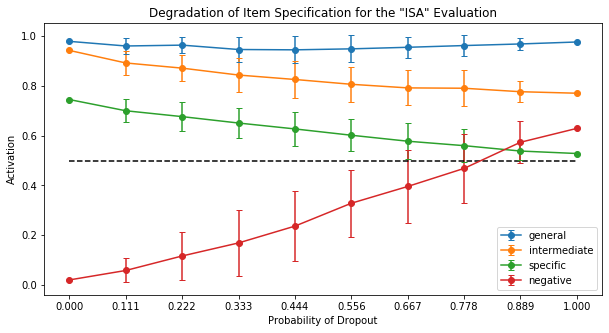

In [242]:
plt.figure(figsize=(10,5))
for k,v in test_formatted.items() :
    to_plot = [v[scale]['mean'] for scale in v.keys()]
    to_plot_error = [v[scale]['std'] for scale in v.keys()]
    plt.errorbar(probabilities_use,to_plot,yerr=to_plot_error,label=k,linestye=None,marker='o',capsize=3)
    
plt.hlines(y=.5,xmin=0,xmax=max(probabilities_use),linestyle='--')
plt.legend()
plt.xticks(probabilities_use)
plt.title('Degradation of Item Specification for the "{}" Evaluation'.format(relation_use))
plt.xlabel('Probability of Dropout')
plt.ylabel('Activation')
plt.show()

## Evaluate differentiation within animal classes.

In [243]:
rep_layers = loaded_model['rep_layer']

In [251]:
rep_layers[0].shape

(10, 12)

In [253]:
names_items

array(['Pine', 'Oak', 'Rose', 'Daisy', 'Robin', 'Canary', 'Sunfish',
       'Salmon', 'Turtle', 'Crocodile'], dtype='<U9')

In [257]:
mynet.state_dict()['i2rep.weight']

tensor([[ 1.3432e+00,  8.7138e-01, -6.0824e-02,  9.9036e-01,  6.7154e-01,
          1.0207e+00,  3.3223e-01, -1.2413e-01,  2.6919e+00,  1.9333e+00],
        [-1.0503e-01, -3.1587e-02,  1.1098e+00,  1.4035e+00, -2.4243e-01,
         -1.2493e-01,  1.1398e+00, -2.9005e-01, -7.1921e-02,  5.7189e-01],
        [ 5.9455e-01, -4.6937e-02,  4.9059e-01,  4.4873e-01, -1.6477e-01,
         -1.6730e-01,  9.0385e-01, -2.2314e-01, -1.8263e-04, -2.6518e-01],
        [ 9.5538e-01,  8.1548e-01, -2.4214e-02, -2.7674e-01, -3.5854e-02,
         -2.2369e-01, -4.4603e-02, -2.5834e-01, -1.7772e-01, -1.1737e-02],
        [-4.6046e-02,  5.3003e-01,  5.1431e-01,  5.0415e-01, -8.6349e-02,
         -2.6173e-04,  8.6046e-01,  1.0638e+00, -2.9256e-01,  1.5710e+00],
        [-1.9848e-05, -1.2544e-02, -2.7417e-04, -2.0192e-01,  1.4394e+00,
          1.7523e+00, -4.0981e-05, -2.3280e-01, -9.9989e-02,  2.7310e-02],
        [ 1.0322e+00,  5.1625e-01,  2.6608e-01, -2.0515e-01, -1.5142e-01,
          3.2799e-01, -9.6446e-0

In [278]:
species = 'Pine'
inputs_per_animal = input_pats[np.where(input_pats[:,np.where(names_items==species)[0]])[0]]
outputs_per_animal = output_pats[np.where(input_pats[:,np.where(names_items==species)[0]])[0]]